In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [3]:
print(os.listdir("../data/"))

['ifood2019_sample_submission.csv', 'sample_submission.csv', 'train_labels.csv', 'train_set', 'val_labels.csv', 'val_set']


In [4]:
df_train = pd.read_csv('../data/train_labels.csv')
df_val   = pd.read_csv('../data/val_labels.csv')

# convert class to string
df_train['label'] = df_train['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)

df_train.head()

,img_name,label
0,train_101733.jpg,211
1,train_101734.jpg,211
2,train_101735.jpg,211
3,train_101736.jpg,211
4,train_101737.jpg,211


In [5]:
df_train.shape, df_val.shape

((118475, 2), (11994, 2))

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# network parameters
sample      = 6000
image_size  = 256
input_shape = (image_size, image_size, 3)
batch_size  = 36
epochs      = 50

kernel_size = 3
filters     = 16
latent_dim  = 128

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
                rescale=1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

Using TensorFlow backend.


In [7]:
df_train = df_train.sample(sample) 
df_val  = df_val.sample(sample)

df_train.shape, df_val.shape

((6000, 2), (6000, 2))

In [11]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_dataframe(
                df_train,
                x_col='img_name',
                y_col='label',    
                class_mode='input',
                directory='../data/train_set/',  # this is the target directory
                shuffle = True,
                target_size=(256, 256),  # all images will be resized to 150x150
                batch_size=batch_size)  # since we use binary_crossentropy loss, we need binary labels

test_generator = test_datagen.flow_from_dataframe(
                df_val,
                x_col='img_name',
                y_col='label',    
                class_mode='input',
                directory='../data/val_set/',  # this is the target directory
                shuffle = False,
                target_size=(256, 256),  # all images will be resized to 150x150
                batch_size=batch_size)  # since we use binary_crossentropy loss, we need binary labels


# Predict train 
train_generator_inf = test_datagen.flow_from_dataframe(
                        df_train,
                        x_col='img_name',
                        y_col='label',    
                        class_mode='input',
                        directory='../data/train_set/',  # this is the target directory
                        shuffle = False,
                        target_size=(256, 256),  # all images will be resized to 150x150
                        batch_size=batch_size)  # since we use binary_crossentropy loss, we need binary labels

C:\Users\Darren\Anaconda3\envs\MacbookPro\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 17 invalid image filename(s) in x_col="img_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 5983 validated image filenames.
Found 6000 validated image filenames.
Found 5983 validated image filenames.


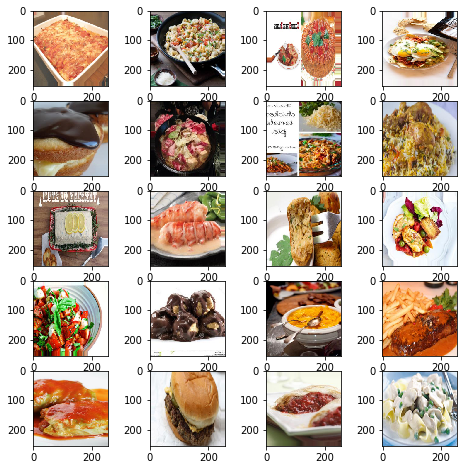

In [12]:
import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = train_generator.next()[0][0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [13]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint

input_img = Input(shape=(256, 256, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((4, 4), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((4, 4))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________

In [14]:
# Save best model
from keras.callbacks import TensorBoard

filepath       = "base-weights.hdf5"
checkpoint     = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [15]:
hist = autoencoder.fit_generator(train_generator,
                                steps_per_epoch=len(train_generator),
                                validation_data=test_generator,
                                validation_steps=len(test_generator),
                                callbacks=callbacks_list,                                 
                                epochs=epochs)


Epoch 1/50
167/167 [==============================] - 623s 4s/step - loss: 0.6748 - val_loss: 0.6759

Epoch 00001: val_loss improved from inf to 0.67587, saving model to base-weights.hdf5
Epoch 2/50
167/167 [==============================] - 597s 4s/step - loss: 0.6766 - val_loss: 0.6755

Epoch 00002: val_loss improved from 0.67587 to 0.67552, saving model to base-weights.hdf5
Epoch 3/50
167/167 [==============================] - 618s 4s/step - loss: 0.6537 - val_loss: 0.6000

Epoch 00003: val_loss improved from 0.67552 to 0.59995, saving model to base-weights.hdf5
Epoch 4/50
167/167 [==============================] - 616s 4s/step - loss: 0.5955 - val_loss: 0.5779

Epoch 00004: val_loss improved from 0.59995 to 0.57795, saving model to base-weights.hdf5
Epoch 5/50
167/167 [==============================] - 616s 4s/step - loss: 0.5771 - val_loss: 0.5787

Epoch 00005: val_loss did not improve from 0.57795
Epoch 6/50
167/167 [==============================] - 615s 4s/step - loss: 0.5681 

KeyboardInterrupt: 

In [ ]:
# Predict Embedding values
# Only encode model
encoder = Model(input_img, autoencoder.layers[8].output)
encoder.summary()

In [ ]:
def predict_generator(model, gen):
    # Predict latent-space map
    pred_maps = encoder.predict_generator(test_generator,steps = len(test_generator))
    # Predict latent-space vector
    pred_enb = pred_maps.reshape(df_val.shape[0], -1)
    return pred_enb

In [ ]:
# Predict latent-space vector
pred_enb = predict_generator(encoder, test_generator)
pred_enb.shape

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plt_reduce_space(x, color=[]):
    '''
    Plot Scatter with color
    '''
    plt.figure(figsize=(8, 8))
    plt.scatter(x[:, 0], x[:, 1], c=color,
            alpha=.4, s=3**2, cmap='viridis')
    plt.show()

In [ ]:
# Reduce dimmension
enb_reduce = TSNE(n_components=2).fit_transform(pred_enb)

In [ ]:
# Plot with merchant_category_id color
plt_reduce_space(enb_reduce, df_val.label.values.astype(int))

In [ ]:
imgs      = train_generator.next()[0]
imgs_pred = autoencoder.predict(imgs)

In [ ]:
def plot_images(imgs, imgs_pred):
    fig=plt.figure(figsize=(10, 20))
    columns = 2
    rows    = 8

    for i in range(1, 9, 2):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
        
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(imgs_pred[i])
    plt.show()
plot_images(imgs, imgs_pred)

In [ ]:
# train
train_enb = predict_generator(encoder, train_generator_inf)
df_emb_train = pd.DataFrame(train_enb)
df_emb_train['img_name'] = df_train.img_name.values

# Val
val_enb = pred_enb#predict_generator(encoder, test_generator)
df_emb_val = pd.DataFrame(val_enb)
df_emb_val['img_name'] = df_val.img_name.values

df_emb_train.shape, df_emb_val.shape

In [ ]:
df_emb_val.head()

In [ ]:
df_emb_train.to_csv('df_emb_train.csv')
df_emb_val.to_csv('df_emb_val.csv')

In [ ]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential

import argparse
import os

In [ ]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [ ]:
from keras.layers import Conv2D, Flatten, Lambda
from keras.utils import plot_model
from keras.layers import Reshape, Conv2DTranspose

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters, kernel_size=kernel_size,
               activation='relu', strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean    = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z_mean, z_log_var = KLDivergenceLayer()([z_mean, z_log_var])

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
print("Encoder")
encoder.summary()
#plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,
                        activation='relu', strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size, activation='sigmoid',
                          padding='same', name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
print("Decoder")
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])

# VAE
vae = Model(inputs, outputs, name='vae')
print("VAE")
vae.summary()

In [ ]:
# reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
# reconstruction_loss *= image_size * image_size
# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# kl_loss = K.sum(kl_loss, axis=-1)
# kl_loss *= -0.5
# vae_loss2 = K.mean(reconstruction_loss + kl_loss)

# def vae_loss(x, x_decoded_mean):
#     xent_loss = binary_crossentropy(x, x_decoded_mean)
#     kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#     return xent_loss + kl_loss

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    lh = K.tf.distributions.Bernoulli(probs=y_pred)

    return - K.sum(lh.log_prob(y_true), axis=-1)

In [ ]:
vae.compile(optimizer='adam', loss=nll)

In [ ]:
filepath       = "base-vae-weights.hdf5"
checkpoint     = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
hist = vae.fit_generator(train_generator,
                        steps_per_epoch=len(train_generator),
                        validation_data=test_generator,
                        validation_steps=len(test_generator),
                        callbacks=callbacks_list,                                 
                        epochs=epochs)

In [ ]:
plt_hist(hist)

In [ ]:
# encoder, from inputs to latent space
encoder = Model(inputs, z)

In [ ]:
def predict_generator(model, gen):
    # Predict latent-space map
    pred_maps = encoder.predict_generator(test_generator,steps = len(test_generator))
    # Predict latent-space vector
    #mean, var, z = np.array(pred_maps)
    return pred_maps

In [ ]:
# Predict latent-space vector
pred_enb = predict_generator(encoder, test_generator)
pred_enb.shape

In [ ]:
# Reduce dimmension
enb_reduce = TSNE(n_components=2).fit_transform(pred_enb)

In [ ]:
# Plot with merchant_category_id color
plt_reduce_space(enb_reduce, df_val.label.values.astype(int))

In [ ]:
imgs      = train_generator.next()[0]
imgs_pred = vae.predict(imgs)

In [ ]:
def plot_images(imgs, imgs_pred):
    fig=plt.figure(figsize=(10, 20))
    columns = 2
    rows    = 8

    for i in range(1, 9, 2):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
        
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(imgs_pred[i])
    plt.show()
plot_images(imgs, imgs_pred)

In [ ]:
# train
train_enb    = predict_generator(encoder, train_generator_inf)
df_emb_train = pd.DataFrame(train_enb)
df_emb_train['img_name'] = df_train.img_name.values

# Val
val_enb    = pred_enb#predict_generator(encoder, test_generator)
df_emb_val = pd.DataFrame(val_enb)
df_emb_val['img_name'] = df_val.img_name.values

df_emb_train.shape, df_emb_val.shape

In [ ]:
df_emb_train.to_csv('df_vae_emb_train.csv')
df_emb_val.to_csv('df_vae_emb_val.csv')

In [ ]:
df_emb_val.head()

In [ ]:
df_val.img_name.shape